In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import build_features_op, utils
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data['motor_vibe'] = np.log1p(train_data['motor_vibe'])
# pca_train = pd.read_csv(r'data\processed\PCA_train_15_feature.csv')
train_data = build_features_op.create_derived_features(train_data)
# train_data = pd.concat([train_data, pca_train], axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data['motor_vibe'] = np.log1p(test_data['motor_vibe'])
# pca_test = pd.read_csv(r'data\processed\PCA_test_15_feature.csv')
test_data = build_features_op.create_derived_features(test_data)
# test_data = pd.concat([test_data, pca_test], axis=1)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

grouped_train = scaled_train_data.groupby('type')

preds = []
ths = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop('type', axis=1).values
    test_group = test_group.drop('type', axis=1).values

    n_features = train_group.shape[1]
    print(n_features)
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    prediction, cosine = evaluation(test_loader, model)
    preds.append(prediction)
    ths.append(cosine)
    print(f"finish {group_name}type")

threshold = np.concatenate(ths)
preds = np.concatenate(preds)
prediction_to_csv(preds)

28
Epoch [1/500], Loss: 0.0835549
Epoch [2/500], Loss: 0.0470699
Epoch [3/500], Loss: 0.0281412
Epoch [4/500], Loss: 0.0175179
Epoch [5/500], Loss: 0.0113543
Epoch [6/500], Loss: 0.0074097
Epoch [7/500], Loss: 0.0052346
Epoch [8/500], Loss: 0.0040793
Epoch [9/500], Loss: 0.0034535
Epoch [10/500], Loss: 0.0030697
Epoch [11/500], Loss: 0.0027700
Epoch [12/500], Loss: 0.0024908
Epoch [13/500], Loss: 0.0022196
Epoch [14/500], Loss: 0.0019613
Epoch [15/500], Loss: 0.0017140
Epoch [16/500], Loss: 0.0014912
Epoch [17/500], Loss: 0.0013020
Epoch [18/500], Loss: 0.0011521
Epoch [19/500], Loss: 0.0010356
Epoch [20/500], Loss: 0.0009473
Epoch [21/500], Loss: 0.0008795
Epoch [22/500], Loss: 0.0008267
Epoch [23/500], Loss: 0.0007815
Epoch [24/500], Loss: 0.0007388
Epoch [25/500], Loss: 0.0006955
Epoch [26/500], Loss: 0.0006521
Epoch [27/500], Loss: 0.0006087
Epoch [28/500], Loss: 0.0005631
Epoch [29/500], Loss: 0.0005152
Epoch [30/500], Loss: 0.0004705
Epoch [31/500], Loss: 0.0004356
Epoch [32/500]

In [ ]:
train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data['motor_vibe'] = np.log1p(train_data['motor_vibe'])
# pca_train = pd.read_csv(r'data\processed\PCA_train_15_feature.csv')
train_data = build_features_op.create_derived_features(train_data)
# train_data = pd.concat([train_data, pca_train], axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data['motor_vibe'] = np.log1p(test_data['motor_vibe'])
# pca_test = pd.read_csv(r'data\processed\PCA_test_15_feature.csv')
test_data = build_features_op.create_derived_features(test_data)

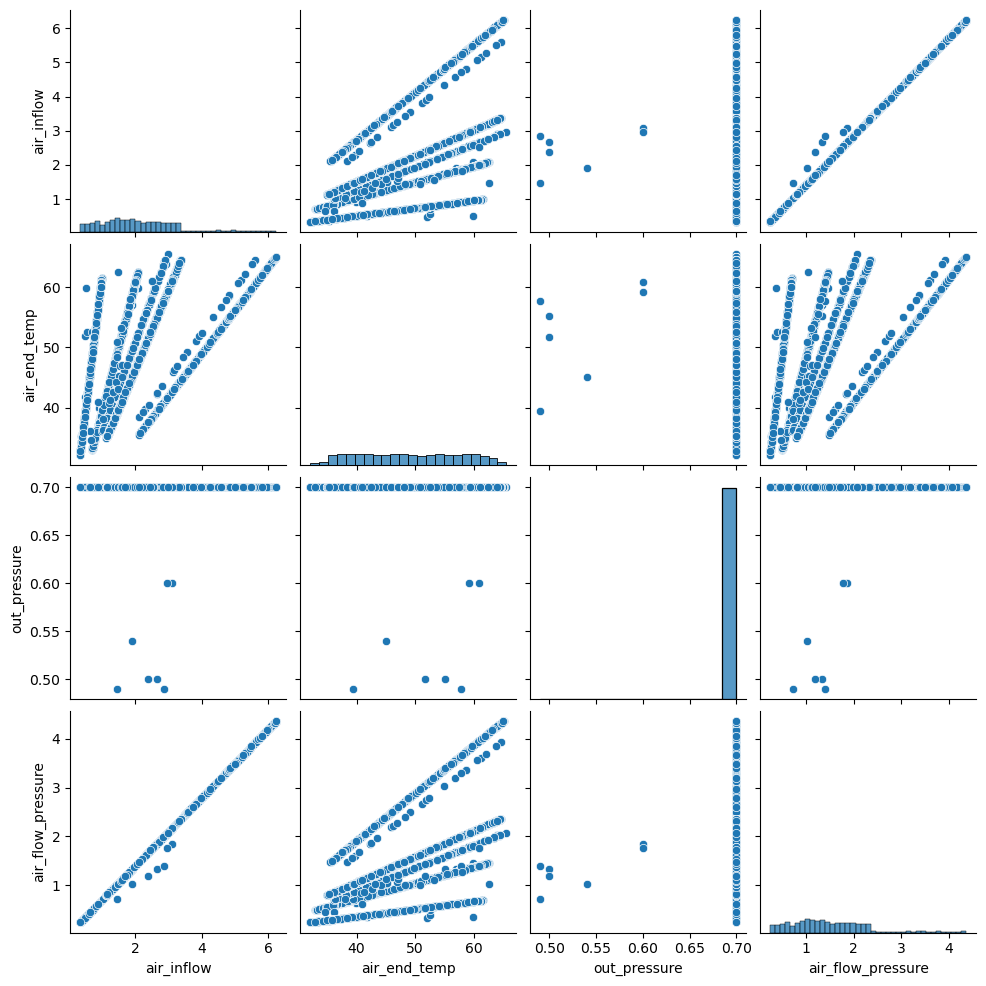

In [2]:
import seaborn as sns
sns.pairplot(test_data[['air_inflow', 'air_end_temp', 'out_pressure', 'air_flow_pressure']])
plt.show()

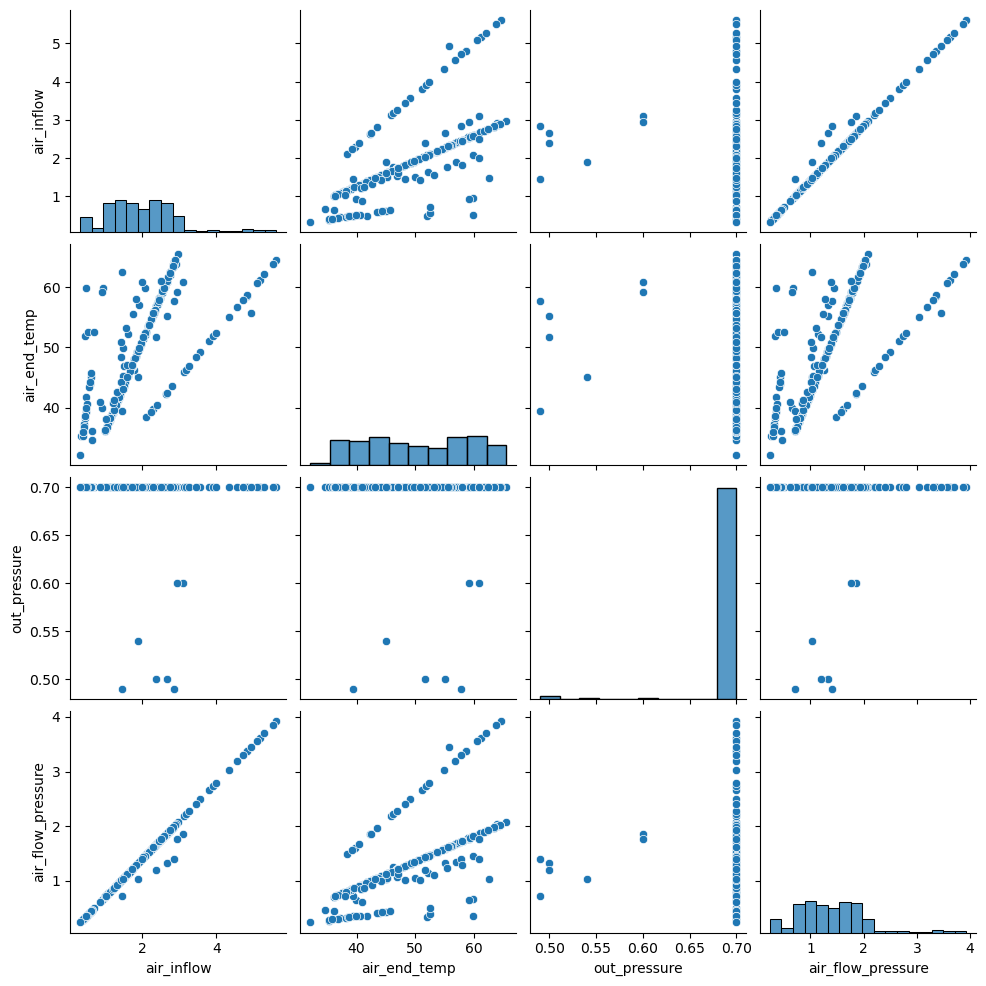

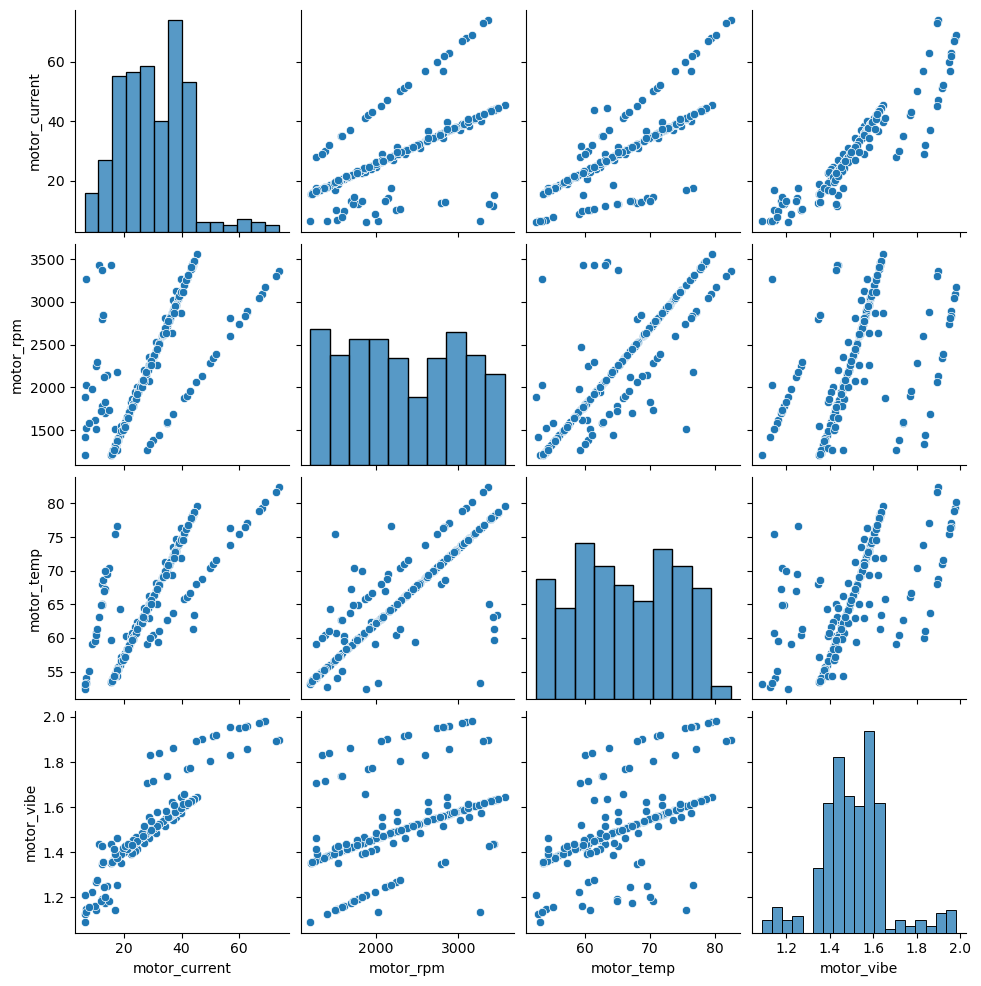

In [3]:
anomaly_plot(test_data, preds)

In [4]:
test_data['label'] = preds
test_data['treshold'] = threshold

In [5]:
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [6]:
yes.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,temp_rise_rate,motor_stability,power_efficiency,label,treshold
count,15.000000,15.000000,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000
mean,2.386000,51.597333,7.000000e-01,30.893333,2527.666667,68.085333,1.478027,7.0,1.670200,12.947766,...,0.000944,0.036747,0.007517,0.641600,130401.003769,0.751677,0.021877,0.054063,0.0,0.999981
std,0.748282,9.906409,1.149190e-16,9.686044,792.453033,8.804113,0.102085,0.0,0.523797,0.016932,...,0.000001,0.002627,0.000232,0.045842,76939.909411,0.051272,0.001402,0.000071,0.0,0.000011
min,1.220000,36.160000,7.000000e-01,15.800000,1293.000000,54.370000,1.313724,7.0,0.854000,12.913386,...,0.000942,0.033710,0.007225,0.588554,26838.586309,0.665073,0.020192,0.053972,0.0,0.999946
25%,1.825000,44.175000,7.000000e-01,23.640000,1934.000000,61.490000,1.404701,7.0,1.277500,12.934909,...,0.000943,0.034715,0.007335,0.606140,64652.988305,0.718168,0.020775,0.054000,0.0,0.999978
50%,2.430000,52.230000,7.000000e-01,31.510000,2578.000000,68.640000,1.488400,7.0,1.701000,12.950820,...,0.000944,0.036269,0.007496,0.633292,120906.835964,0.760927,0.021684,0.054051,0.0,0.999985
75%,2.975000,59.375000,7.000000e-01,38.500000,3150.000000,75.000000,1.558142,7.0,2.082500,12.962937,...,0.000945,0.038481,0.007686,0.671961,188973.594150,0.791664,0.022851,0.054117,0.0,0.999988
max,3.360000,64.450000,7.000000e-01,43.460000,3556.000000,79.510000,1.605430,7.0,2.352000,12.969697,...,0.000946,0.041143,0.007885,0.718220,248109.171777,0.810590,0.024163,0.054207,0.0,0.999990


In [8]:
no

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,temp_rise_rate,motor_stability,power_efficiency,label,treshold
7342,1.60,45.04,0.7,24.57,1923.0,61.37,1.451614,7,1.120,15.356250,...,0.000832,0.031402,0.007665,0.573178,68586.009787,0.733909,0.023653,0.045584,1,0.914265
7348,2.76,62.36,0.7,42.28,3309.0,76.77,1.617406,7,1.932,15.318841,...,0.000834,0.028252,0.007270,0.515695,226282.421559,0.812296,0.021068,0.045695,1,0.951468
7359,1.48,43.15,0.7,22.64,1772.0,59.69,1.430311,7,1.036,15.297297,...,0.000835,0.031993,0.007711,0.583939,57381.341013,0.722902,0.023962,0.045760,1,0.918264
7360,1.74,47.05,0.7,26.63,2084.0,63.16,1.472472,7,1.218,15.304598,...,0.000835,0.031062,0.007617,0.567028,81717.663970,0.744934,0.023313,0.045738,1,0.918877


143
0
27
26
13
29
102
4


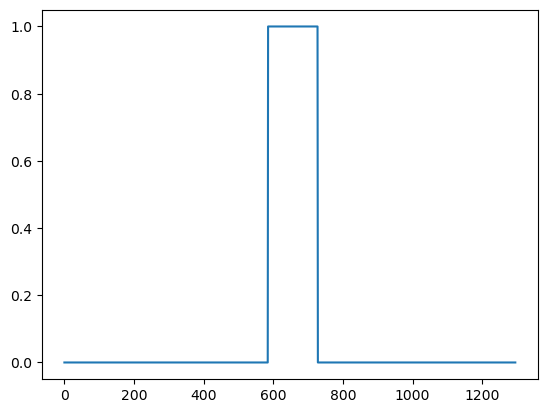

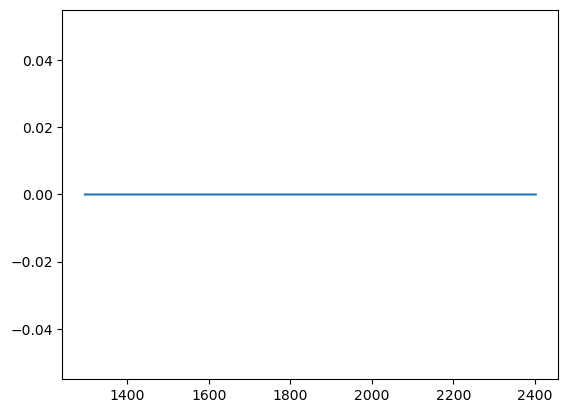

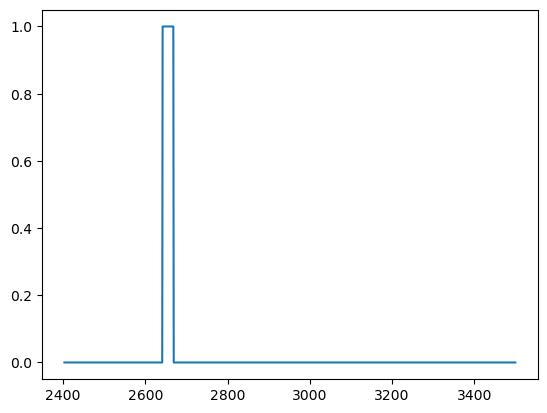

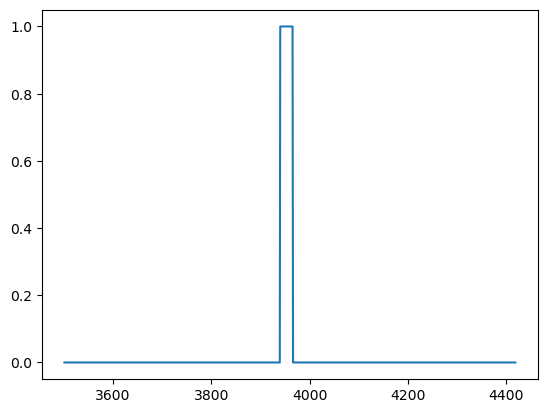

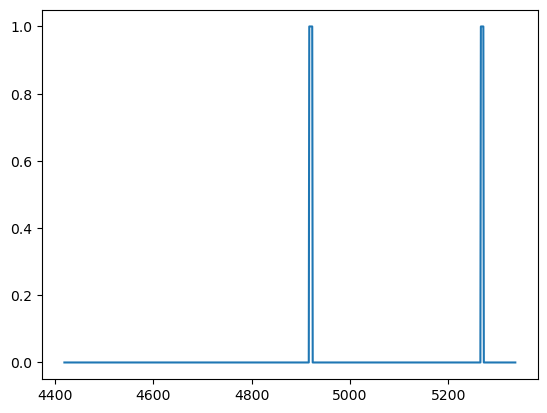

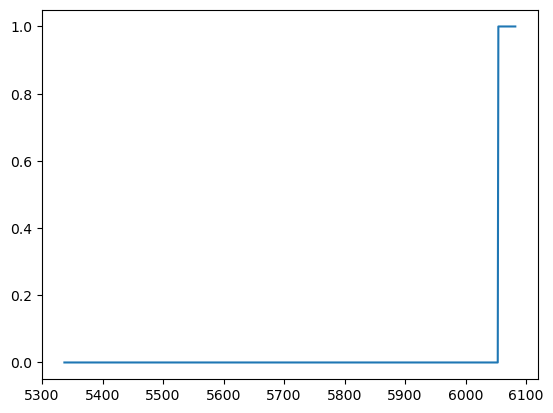

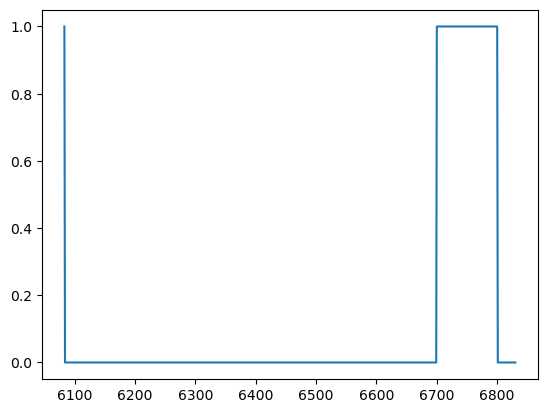

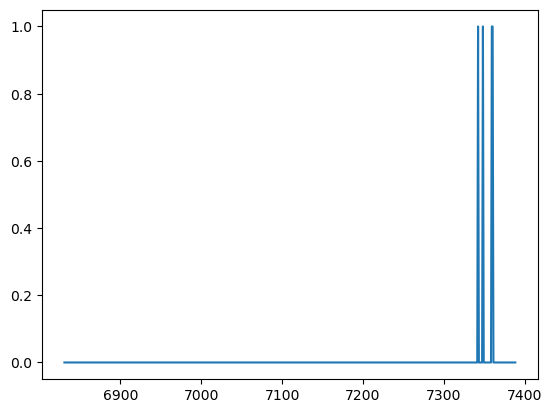

In [10]:
predictions = pd.read_csv(r"C:\Project_MB\Anomaly-Detection-of-Air-Compressor\data\submission\20230409_234219submission.csv")

predictions00 = predictions[:1296]
predictions01 = predictions[1296:2403]
predictions02 = predictions[2403:3501]
predictions03 = predictions[3501:4419]
predictions04 = predictions[4419:5337]
predictions05 = predictions[5337:6083]
predictions06 = predictions[6083:6831]
predictions07 = predictions[6831:]

print(len(predictions00[predictions00['label'] == 1]))
print(len(predictions01[predictions01['label'] == 1]))
print(len(predictions02[predictions02['label'] == 1]))
print(len(predictions03[predictions03['label'] == 1]))
print(len(predictions04[predictions04['label'] == 1]))
print(len(predictions05[predictions05['label'] == 1]))
print(len(predictions06[predictions06['label'] == 1]))
print(len(predictions07[predictions07['label'] == 1]))

predict_type = [predictions00, predictions01, predictions02, predictions03, predictions04, predictions05, predictions06, predictions07]

for type in predict_type:
    plt.plot(type['label'])
    plt.show()
    